# Scraping data from Skytrax

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [93]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100
reviews = []

for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")  

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [94]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head(10)

,reviews
0,✅ Trip Verified | The worst business class ex...
1,Not Verified | Quite possibly the worst busin...
2,Not Verified | I will never be flying with BA...
3,✅ Trip Verified | On the my trip to Mexico Ci...
4,✅ Trip Verified | I upgraded at check in to C...
5,✅ Trip Verified | I bought a return trip with...
6,✅ Trip Verified | Poor from start to finish. ...
7,✅ Trip Verified | Communication and customer s...
8,✅ Trip Verified | That was supposed to be my ...
9,✅ Trip Verified | Have no fear when your BA f...


In [95]:
df["verify"] = df["reviews"].str.split('|',expand= True)[0]
df["reviews"] = df["reviews"].str.split('|',expand= True)[1]


In [96]:
df["verify"].describe()

count                 1000
unique                   4
top       ✅ Trip Verified 
freq                   767
Name: verify, dtype: object

In [97]:
df["verify"].unique()

array(['✅ Trip Verified ', 'Not Verified ', 'cNot Verified ',
       '❎ Not Verified '], dtype=object)

In [98]:
reject = ['Not Verified ', 'cNot Verified ',
       '❎ Not Verified ']
df["verify"] = [0 if i in reject else 1 for i in df["verify"]]

In [101]:
df.head()

,reviews,verify
0,The worst business class experience. Ground ...,1
1,Quite possibly the worst business class I ha...,0
2,I will never be flying with BA again. This i...,0
3,"On the my trip to Mexico City, I had the opp...",1
4,I upgraded at check in to Club Europe seat 1...,1


In [109]:
df.drop(df[df['verify'] == 0].index, inplace=True)

,reviews,verify
0,The worst business class experience. Ground ...,1
3,"On the my trip to Mexico City, I had the opp...",1
4,I upgraded at check in to Club Europe seat 1...,1
5,"I bought a return trip with BA, through Webj...",1
6,Poor from start to finish. Six months after ...,1


In [113]:
print(df.shape)
df.head()

(767, 2)


,reviews,verify
0,The worst business class experience. Ground ...,1
3,"On the my trip to Mexico City, I had the opp...",1
4,I upgraded at check in to Club Europe seat 1...,1
5,"I bought a return trip with BA, through Webj...",1
6,Poor from start to finish. Six months after ...,1


In [115]:
df.to_csv("F:/Britich Airline/BA_reviews.csv")

# Data Preprocessing 

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [2]:
data = pd.read_csv("F:/Britich Airline/BA_reviews.csv")
data.drop('Unnamed: 0',axis=1,inplace= True)
data.head()

,reviews,verify
0,The worst business class experience. Ground ...,1
1,"On the my trip to Mexico City, I had the opp...",1
2,I upgraded at check in to Club Europe seat 1...,1
3,"I bought a return trip with BA, through Webj...",1
4,Poor from start to finish. Six months after ...,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  767 non-null    object
 1   verify   767 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ KB


In [4]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    """
    str.maketrans('', '', string.punctuation): The str.maketrans() function is used to create a translation table for characters. In this case, we are creating a translation table to remove or delete certain characters from the text.

    The first argument '' represents the characters that need to be replaced. In this case, we are not replacing any characters, so it is an empty string.
    The second argument '' represents the characters to be replaced with. Again, since we are not replacing any characters, it is an empty string.
    The third argument string.punctuation represents the characters that need to be deleted or removed from the text.
    """
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

In [6]:
preprocessed_data = pd.DataFrame()
preprocessed_data["reviews"] = data["reviews"].apply(preprocess_text)

In [7]:
preprocessed_data.head()

,reviews
0,worst business class experience ground crew si...
1,trip mexico city opportunity experience ba lon...
2,upgraded check club europe seat 1d excellent e...
3,bought return trip ba webjet australia last ye...
4,poor start finish six month purchasing ticket ...


# Data Analysis

### Sentiment Analysis

In [8]:
import pandas as pd
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

import nltk

In [9]:
def analyze_sentiment_textblob(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    """
    The polarity score ranges from -1 to 1,where
    -1 represents a negative sentiment,
    0 represents a neutral sentiment, 
    and 1 represents a positive sentiment.
    """
    if sentiment > 0.01:
        return 'Positive'
    elif sentiment < -0.01:
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment_textblob'] = preprocessed_data['reviews'].apply(analyze_sentiment_textblob)
data.head()

,reviews,verify,sentiment_textblob
0,The worst business class experience. Ground ...,1,Negative
1,"On the my trip to Mexico City, I had the opp...",1,Positive
2,I upgraded at check in to Club Europe seat 1...,1,Positive
3,"I bought a return trip with BA, through Webj...",1,Positive
4,Poor from start to finish. Six months after ...,1,Negative


In [13]:
#Analyze sentiment using VADER:
def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.01:
        return 'Positive'
    elif compound_score <= -0.01:
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment_vader'] = preprocessed_data['reviews'].apply(analyze_sentiment_vader)
data.head(10)

,reviews,verify,sentiment_textblob,sentiment_vader
0,The worst business class experience. Ground ...,1,Negative,Positive
1,"On the my trip to Mexico City, I had the opp...",1,Positive,Positive
2,I upgraded at check in to Club Europe seat 1...,1,Positive,Positive
3,"I bought a return trip with BA, through Webj...",1,Positive,Negative
4,Poor from start to finish. Six months after ...,1,Negative,Negative
5,Communication and customer service non existe...,1,Negative,Negative
6,That was supposed to be my flight but it was...,1,Positive,Negative
7,Have no fear when your BA flight is operated...,1,Positive,Positive
8,London Heathrow to Istanbul at the start of ...,1,Positive,Positive
9,I am a British Airways Gold Guest List member...,1,Positive,Positive


In [14]:
sentiment_distribution_verified_textblob = data['sentiment_textblob'].value_counts(normalize=True)
sentiment_distribution_verified_textblob

Positive    0.620600
Negative    0.325945
Neutral     0.053455
Name: sentiment_textblob, dtype: float64

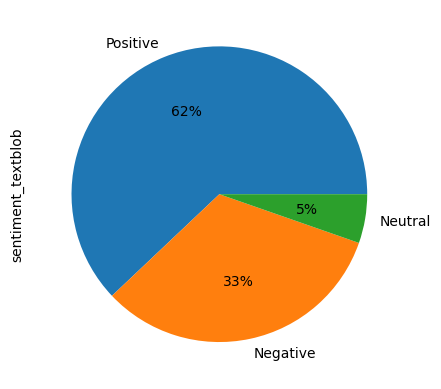

In [57]:
sentiment_distribution_verified_textblob.plot(kind='pie',autopct='%1.0f%%');

In [16]:
sentiment_distribution_verified_vader = data['sentiment_vader'].value_counts(normalize=True)
sentiment_distribution_verified_vader

Positive    0.572360
Negative    0.419817
Neutral     0.007823
Name: sentiment_vader, dtype: float64

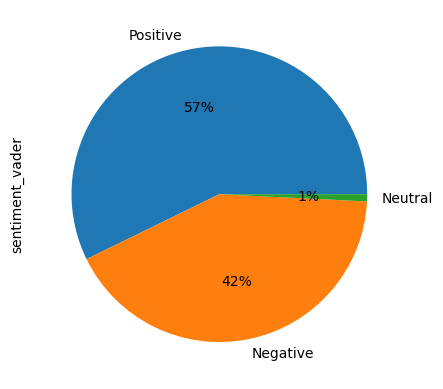

In [59]:
sentiment_distribution_verified_vader.plot(kind='pie',autopct='%1.0f%%');

### Topic Modeling

In [17]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models

In [36]:
# Tokenize and remove stop words
stop_words = set(stopwords.words('english'))

def preprocess_text2(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

preprocessed_data2 = pd.DataFrame()
preprocessed_data2["reviews"] = data["reviews"].apply(preprocess_text2)
preprocessed_data2.head()

,reviews
0,"[worst, business, class, experience, ground, c..."
1,"[trip, mexico, city, opportunity, experience, ..."
2,"[upgraded, check, club, europe, seat, excellen..."
3,"[bought, return, trip, ba, webjet, australia, ..."
4,"[poor, start, finish, six, months, purchasing,..."


In [39]:
# Create a dictionary from the preprocessed text
dictionary = corpora.Dictionary(preprocessed_data2["reviews"])
# Create a bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in preprocessed_data2["reviews"]]

# Train the LDA model
num_topics = 5  # Number of topics to identify
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Print the identified topics
for topic_id, topic in lda_model.print_topics():
    print(f'Topic {topic_id}: {topic}\n')

Topic 0: 0.033*"flight" + 0.013*"ba" + 0.011*"good" + 0.009*"time" + 0.009*"crew" + 0.008*"service" + 0.007*"london" + 0.007*"cabin" + 0.006*"one" + 0.006*"staff"

Topic 1: 0.026*"flight" + 0.014*"ba" + 0.009*"london" + 0.009*"service" + 0.008*"customer" + 0.008*"us" + 0.008*"get" + 0.008*"airport" + 0.008*"british" + 0.008*"hours"

Topic 2: 0.019*"flight" + 0.013*"ba" + 0.009*"seat" + 0.009*"crew" + 0.008*"food" + 0.008*"good" + 0.007*"service" + 0.007*"seats" + 0.007*"time" + 0.006*"us"

Topic 3: 0.019*"class" + 0.018*"flight" + 0.015*"ba" + 0.015*"business" + 0.014*"service" + 0.010*"food" + 0.010*"seat" + 0.008*"cabin" + 0.008*"seats" + 0.007*"time"

Topic 4: 0.020*"ba" + 0.015*"flight" + 0.007*"staff" + 0.007*"london" + 0.007*"crew" + 0.006*"would" + 0.005*"seat" + 0.005*"service" + 0.005*"one" + 0.005*"british"



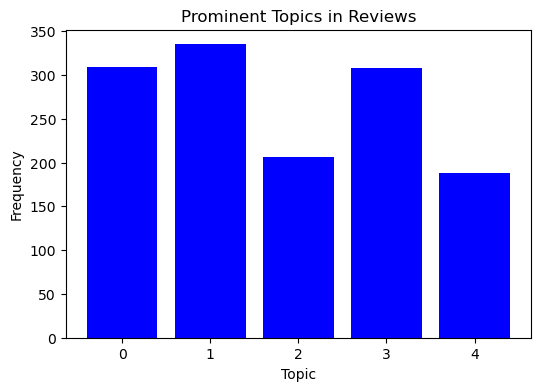

In [53]:
# Get the topic distribution for each document
topic_distributions = [lda_model.get_document_topics(doc) for doc in corpus]

# Count the frequency of each topic
topic_counts = [0] * num_topics
for doc_topics in topic_distributions:
    for topic, _ in doc_topics:
        topic_counts[topic] += 1

# Plot the bar chart
plt.figure(figsize=(6, 4))
plt.bar(range(num_topics), topic_counts, color='blue')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.title('Prominent Topics in Reviews')
plt.xticks(range(num_topics))
plt.show()

### Word Cloud

In [42]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

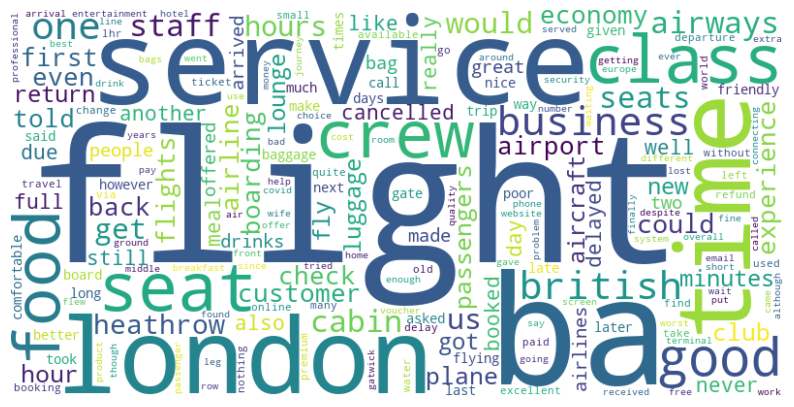

In [44]:
# Combine all the preprocessed tokens into a single list
all_tokens = [token for tokens in preprocessed_data2["reviews"] for token in tokens]

# Create a frequency distribution of the tokens
word_freq = nltk.FreqDist(all_tokens)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()